In [26]:
import numpy as np
from scipy import optimize
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp
import yaml

import random
from itertools import chain, combinations, tee
import time

import glob
import os


plt.rcParams['text.usetex'] = True

# Functions

In [2]:
def station_to_city(station_name):
    if "East_Palo_Alto" in station_name:
        city_name = "East Palo Alto"
    elif "Palo_Alto" in station_name:
        city_name = "Palo Alto"
    elif "Menlo_Park" in station_name:
        city_name = "Menlo Park"
    elif "Redwood_City" in station_name:
        city_name = "Redwood City"
    elif "Belmont" in station_name:
        city_name = "Belmont"
    elif "San_Mateo" in station_name:
        city_name = "San Mateo"
    elif "Burlingame" in station_name:
        city_name = "Burlingame"
    elif "Millbrae" in station_name:
        city_name = "Millbrae"
    else:
        assert 1 == 0, "There should be no other case."
    return city_name

# Latency Function Inference

In [3]:
directory_path_speed = '../data/pems_speed___101_N_Sep_to_Nov_2024/'
directory_path_flow = '../data/pems_flow___101_N_Sep_to_Nov_2024/'

speed_file_list = [f for f in os.listdir(directory_path_speed) \
                  if os.path.isfile(os.path.join(directory_path_speed, f)) and f[-1] == 'x' and f[0] != "~"]
speed_file_list.sort()

flow_file_list = [speed_file[:4] + speed_file[10:] for speed_file in speed_file_list]

# flow_file_list = speed_file_list
# speed_file_list

In [4]:
# flow_file_list

In [5]:
timestamp_list = []

date_list_Sep = ['3', '4', '5', '6', '9', '10', '11', '12', '13', '16', \
                 '17', '18', '19', '20', '23', '24', '25', '26', '27']
date_list_Oct = ['01', '02', '03', '04', '07', '08', '09', '10', '11', '14', \
                 '15', '16', '17', '18', '21', '22', '23', '24', '25', '28', \
                 '29', '30', '31']
date_list_Nov = ['01', '04', '05', '06', '07', '08', '12', '13', '14', '15', \
                 '18', '19', '20', '21', '22']

# timestamp_options = [6, 7, 8, 9, 10, 11, 12]
timestamp_options = list(range(24))

for date in date_list_Sep:
    for timestamp in timestamp_options:
        timestamp_list += ['9/' + date + '/2024 ' + str(timestamp) + ':00']
        
for date in date_list_Oct:
    for timestamp in timestamp_options:
        timestamp_list += ['10/' + date + '/2024 ' + str(timestamp) + ':00']
        
for date in date_list_Nov:
    for timestamp in timestamp_options:
        timestamp_list += ['11/' + date + '/2024 ' + str(timestamp) + ':00']

timestamp_list

['9/3/2024 0:00',
 '9/3/2024 1:00',
 '9/3/2024 2:00',
 '9/3/2024 3:00',
 '9/3/2024 4:00',
 '9/3/2024 5:00',
 '9/3/2024 6:00',
 '9/3/2024 7:00',
 '9/3/2024 8:00',
 '9/3/2024 9:00',
 '9/3/2024 10:00',
 '9/3/2024 11:00',
 '9/3/2024 12:00',
 '9/3/2024 13:00',
 '9/3/2024 14:00',
 '9/3/2024 15:00',
 '9/3/2024 16:00',
 '9/3/2024 17:00',
 '9/3/2024 18:00',
 '9/3/2024 19:00',
 '9/3/2024 20:00',
 '9/3/2024 21:00',
 '9/3/2024 22:00',
 '9/3/2024 23:00',
 '9/4/2024 0:00',
 '9/4/2024 1:00',
 '9/4/2024 2:00',
 '9/4/2024 3:00',
 '9/4/2024 4:00',
 '9/4/2024 5:00',
 '9/4/2024 6:00',
 '9/4/2024 7:00',
 '9/4/2024 8:00',
 '9/4/2024 9:00',
 '9/4/2024 10:00',
 '9/4/2024 11:00',
 '9/4/2024 12:00',
 '9/4/2024 13:00',
 '9/4/2024 14:00',
 '9/4/2024 15:00',
 '9/4/2024 16:00',
 '9/4/2024 17:00',
 '9/4/2024 18:00',
 '9/4/2024 19:00',
 '9/4/2024 20:00',
 '9/4/2024 21:00',
 '9/4/2024 22:00',
 '9/4/2024 23:00',
 '9/5/2024 0:00',
 '9/5/2024 1:00',
 '9/5/2024 2:00',
 '9/5/2024 3:00',
 '9/5/2024 4:00',
 '9/5/2024 5:00',


In [6]:
# print("speed_file_list[0]:", speed_file_list[0])
# directory_path = "../data/pems_speed___101_N_Sep_to_Nov_2024/"
# df_speed_file = pd.read_excel(directory_path + speed_file_list[0], index_col=0)

In [7]:
speed_file_temp = speed_file_list[0]
print("speed_file_temp:", speed_file_temp)
# df_speed_file_temp = pd.read_excel('../data/pems_speed___101_N_Sep_to_Nov_2024/001_speed___402376_Palo_Alto___main.xlsx', index_col=0)

df_speed_file_temp = pd.read_excel(directory_path_speed + speed_file_temp, index_col=0)

df_speed_file_temp.loc["9/3/2024 0:00", "Speed (mph)"]
# df_speed_file_temp.loc["9/3/2024 0:00", "Speed (mph)"]


speed_file_temp: 001_speed___402376_Palo_Alto___main.xlsx


63.9

In [8]:
start_time = time.time()

# directory_path = "../data/pems_speed___101_N_Sep_to_Nov_2024/"
city_list = ["Palo Alto", "East Palo Alto", "Redwood City", "Belmont", "San Mateo", "Burlingame", "Millbrae"]

speed_dict = {}

for speed_file in speed_file_list:
    speed_dict[speed_file[:-5]] = {}
    
    print("File:", directory_path_speed + speed_file)
    
    df_speed_file = pd.read_excel(directory_path_speed + speed_file, index_col=0)

    for timestamp in timestamp_list:
        speed_dict[speed_file[:-5]][timestamp] = df_speed_file.loc[timestamp, "Speed (mph)"]
#         df_speed_file_temp.loc["9/3/2024 0:00", "Speed (mph)"]

end_time = time.time()

print()
print("Time:", end_time - start_time)



File: ../data/pems_speed___101_N_Sep_to_Nov_2024/001_speed___402376_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/002_speed___402377_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/003_speed___402379_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/005_speed___425697_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/007_speed___402380_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/008_speed___404529_East_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/009_speed___422116_East_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/012_speed___400859_East_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/014_speed___404533_East_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/016_speed___400981_East_Palo_Alto___main.xlsx
File: ../data/pems_speed___101_N_Sep_to_Nov_2024/017_speed___402398_East_Pa

In [9]:
start_time = time.time()

num_gp_lanes = 4

flow_dict = {}

for flow_file in flow_file_list:
    flow_dict[flow_file[:-5]] = {}
    
    print("File:", directory_path_flow + flow_file)
    
    df_flow_file = pd.read_excel(directory_path_flow + flow_file, index_col=0)
    
    for timestamp in timestamp_list:
        flow_dict[flow_file[:-5]][timestamp] = df_flow_file.loc[timestamp, "Flow (Veh/Hour)"] / num_gp_lanes
        
end_time = time.time()

print()
print("Time:", end_time - start_time)

# flow_file_list


File: ../data/pems_flow___101_N_Sep_to_Nov_2024/001___402376_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/002___402377_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/003___402379_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/005___425697_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/007___402380_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/008___404529_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/009___422116_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/012___400859_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/014___404533_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/016___400981_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/017___402398_East_Palo_Alto___main.xlsx
File: ../data/pems_flow___101_N_Sep_to_Nov_2024/018___404

In [10]:
directory_path_latency = '../data/pems_latency_inference___101_N_Sep_to_Nov_2024/'
distance_file = "distances_between_sensors.xlsx"

df_distance_file = pd.read_excel(directory_path_latency + distance_file, index_col=0)
distance_dict = {}

# df_distance_file.loc["Data Category", "0"]
# df_distance_file.loc["Start City", 10]

for sub_edge in list(df_distance_file.columns):
    distance_dict[sub_edge] = {}
    distance_dict[sub_edge]["Start City"] = df_distance_file.loc["Start City", sub_edge]
    distance_dict[sub_edge]["Start Station"] = df_distance_file.loc["Start Station", sub_edge]
    distance_dict[sub_edge]["End Station"] = df_distance_file.loc["End Station", sub_edge]
    distance_dict[sub_edge]["Distance"] = df_distance_file.loc["Distances Between Sensors (miles)", sub_edge]


In [11]:
distance_dict

{0: {'Start City': 'Palo Alto',
  'Start Station': '001_speed___402376_Palo_Alto___main',
  'End Station': '002_speed___402377_Palo_Alto___main',
  'Distance': 0.4},
 1: {'Start City': 'Palo Alto',
  'Start Station': '002_speed___402377_Palo_Alto___main',
  'End Station': '003_speed___402379_Palo_Alto___main',
  'Distance': 0.5},
 2: {'Start City': 'Palo Alto',
  'Start Station': '003_speed___402379_Palo_Alto___main',
  'End Station': '005_speed___425697_Palo_Alto___main',
  'Distance': 0.39},
 3: {'Start City': 'Palo Alto',
  'Start Station': '005_speed___425697_Palo_Alto___main',
  'End Station': '007_speed___402380_Palo_Alto___main',
  'Distance': 0.11},
 4: {'Start City': 'East Palo Alto',
  'Start Station': '008_speed___404529_East_Palo_Alto___main',
  'End Station': '009_speed___422116_East_Palo_Alto___main',
  'Distance': 0.57},
 5: {'Start City': 'East Palo Alto',
  'Start Station': '009_speed___422116_East_Palo_Alto___main',
  'End Station': '012_speed___400859_East_Palo_Alto_

In [12]:
flow_time_dict = {}
flow_threshold = 100

for city in city_list:
    flow_time_dict[city] = []
    
    station_speed_list = []
    station_speed_list += [distance_dict[sub_edge]["Start Station"] for sub_edge in distance_dict.keys() \
                           if distance_dict[sub_edge]["Start City"] == city]
    station_speed_list += [distance_dict[sub_edge]["End Station"] for sub_edge in distance_dict.keys() \
                           if distance_dict[sub_edge]["Start City"] == city]
    station_speed_list = list(set(station_speed_list))
    
    station_flow_list = [station_speed[:3] + station_speed[9:] for station_speed in station_speed_list]
    
    sub_edge_list = [key for key in distance_dict.keys() if distance_dict[key]["Start City"] == city]
    
    print("station_speed_list:\n", station_speed_list)
    print()
    
    for timestamp in timestamp_list:
        # TODO: Compute flow array
#         flow_array = np.array([flow_dict[station][timestamp] for station in station_flow_list \
#                                if flow_dict[station][timestamp] >= flow_threshold])
        flow_array = np.array([flow_dict[station][timestamp] for station in station_flow_list])
        average_flow = np.mean(flow_array)
        
        travel_time = sum([distance_dict[sub_edge]["Distance"] * 2 \
                           / (speed_dict[distance_dict[sub_edge]["Start Station"]][timestamp] \
                              + speed_dict[distance_dict[sub_edge]["Start Station"]][timestamp]) \
                           for sub_edge in sub_edge_list])
        
#         # TODO: Compute travel time
        
        flow_time_dict[city] += [(average_flow, travel_time)]
        
flow_time_dict["Millbrae"]

station_speed_list:
 ['002_speed___402377_Palo_Alto___main', '007_speed___402380_Palo_Alto___main', '001_speed___402376_Palo_Alto___main', '005_speed___425697_Palo_Alto___main', '003_speed___402379_Palo_Alto___main']

station_speed_list:
 ['012_speed___400859_East_Palo_Alto___main', '017_speed___402398_East_Palo_Alto___main', '014_speed___404533_East_Palo_Alto___main', '009_speed___422116_East_Palo_Alto___main', '016_speed___400981_East_Palo_Alto___main', '018_speed___404534_Menlo_Park___main', '008_speed___404529_East_Palo_Alto___main']

station_speed_list:
 ['034_speed___401834_Redwood_City___main', '037_speed___401929_Redwood_City___main', '035_speed___401833_Redwood_City___main', '025_speed___401874_Redwood_City___main', '043_speed___401869_Redwood_City___main', '024_speed___405673_Redwood_City___main', '023_speed___401872_Redwood_City___main', '041_speed___401832_Redwood_City___main', '031_speed___404532_Redwood_City___main', '039_speed___401882_Redwood_City___main', '044_speed___

[(326.5, 0.03937984629395375),
 (235.45454545454547, 0.03977980091044437),
 (192.47727272727272, 0.039463796107286654),
 (241.47727272727272, 0.039188432655682684),
 (381.8636363636364, 0.03927943635769159),
 (821.8409090909091, 0.03920647299614409),
 (1229.2727272727273, 0.040746231370044184),
 (1519.75, 0.04147775501318577),
 (1541.4318181818182, 0.041214404741934135),
 (1397.2045454545455, 0.041867124592788164),
 (1270.409090909091, 0.041832120101531894),
 (1209.659090909091, 0.041152102139518504),
 (1261.2272727272727, 0.04105883786983182),
 (1213.1818181818182, 0.041216978886368334),
 (804.6136363636364, 0.06075964623190033),
 (1008.9318181818181, 0.09425616091007938),
 (1451.5, 0.040947827258144984),
 (1288.9772727272727, 0.08355329488586902),
 (1117.0, 0.11117222492780933),
 (1120.0, 0.040418288485646554),
 (943.5454545454545, 0.03968386153465151),
 (857.7272727272727, 0.03886772265554756),
 (616.3181818181819, 0.038874083948936065),
 (463.8181818181818, 0.03917885283818514),
 (

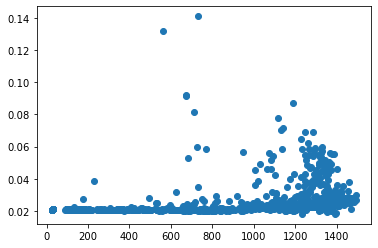

In [13]:
# city_to_plot = "Millbrae"
city_to_plot = "Palo Alto"
x_values = np.array([flow_time[0] for flow_time in flow_time_dict[city_to_plot]])
y_values = np.array([flow_time[1] for flow_time in flow_time_dict[city_to_plot]])

plt.scatter(x_values, y_values)
plt.show()

In [14]:
city_list

['Palo Alto',
 'East Palo Alto',
 'Redwood City',
 'Belmont',
 'San Mateo',
 'Burlingame',
 'Millbrae']

In [15]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def piecewise_linear_simplified(x, x0, y0, k):
    return np.piecewise(x, [x < x0], [lambda x:y0, lambda x:k*x + y0-k*x0])

# p , e = optimize.curve_fit(piecewise_linear, x, y)

In [16]:
latency_params = {}
num_flow_potential_bends = 100

for city in city_list:
    flows = np.array([flow_time_tuple[0] for flow_time_tuple in flow_time_dict[city]], dtype = float)
    times = np.array([flow_time_tuple[1] for flow_time_tuple in flow_time_dict[city]])
    
    max_flow = np.max(flows)
    min_flow = np.min(flows)
    
    print()
    print("city:", city)
    print("min_flow:", min_flow)
    print("max_flow:", max_flow)
#     print("list(range(num_flow_potential_bends))[1:]:", list(range(num_flow_potential_bends))[1:])
    
    flow_potential_bends_arr = list(range(num_flow_potential_bends))[int(num_flow_potential_bends/2):]
    flow_potential_bend_list = min_flow + (max_flow - min_flow) * np.array(flow_potential_bends_arr) / num_flow_potential_bends
    
#     print("flow_potential_bend_list:", flow_potential_bend_list)
    
    best_flow_time_slope_error = []
    
    objective_value_list = []
    latency_0_list = []
    slope_list = []
    
    for flow_potential_bend in flow_potential_bend_list:
        
#         flow_times_at_constant = [pair for pair in flow_time_dict[city] if pair[0] <= flow_potential_bend]
#         flow_times_at_slope = [pair for pair in flow_time_dict[city] if pair[0] > flow_potential_bend]
        
        flows_at_constant = np.array([pair[0] for pair in flow_time_dict[city] if pair[0] <= flow_potential_bend])
        times_at_constant = np.array([pair[1] for pair in flow_time_dict[city] if pair[0] <= flow_potential_bend])
        flows_at_slope = np.array([pair[0] for pair in flow_time_dict[city] if pair[0] > flow_potential_bend])
        times_at_slope = np.array([pair[1] for pair in flow_time_dict[city] if pair[0] > flow_potential_bend])
        
        # TODO: Set up optimization problem.
        
        # Variables:
        latency_0 = cp.Variable(1)
        slope = cp.Variable(1)
        
        # Objectives:
        func = 0.0
        func += cp.sum_squares(times_at_constant - latency_0 * np.ones(flows_at_constant.shape[0]))
        func += cp.sum_squares(times_at_slope - latency_0 * np.ones(flows_at_slope.shape[0]) \
                                  - slope * (flows_at_slope - flow_potential_bend * np.ones(flows_at_slope.shape[0]) ))

        objective = cp.Minimize(func)
        
# #         for pair in flow_times_at_constant:
#             func += cp.sum_squares([pair[1] - cp.ones(len(flow_times_at_constant)) @ latency_0])
# #         for pair in flow_times_at_slope:
#             func += cp.sum_squares([pair[1] - cp.ones(len(flow_times_at_slope)) @ latency_0 \
#                                     - (x - cp.ones() * flow_potential_bend) ])
        
        # Constraints:
        constraints = []
        constraints += [latency_0 >= 0.0]
        constraints += [slope >= 0.0]
        
        # Solve problem:
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
        objective_value_list += [prob.value]
        latency_0_list += [latency_0.value]
        slope_list += [slope.value]
        
#         if best_flow_time_slope_error == []:
    
    argmin_objective = objective_value_list.index(min(objective_value_list))
    latency_params[city] = [latency_0_list[argmin_objective][0] * 60, slope_list[argmin_objective][0] * 60,\
                            flow_potential_bend_list[argmin_objective]]
    


## coeff_input: const, slope, x-coordinate of transition point


#     print("flows:", flows)
#     print()
#     print("times:", times)
#     print()
#     print()
    
    # params - x of junction point, y of junction point, slope of 1st segment, slope of 2nd segment
#     params, _ = optimize.curve_fit(piecewise_linear_simplified, flows, times)
    
#     latency_params[city] = list(params)




city: Palo Alto
min_flow: 25.2
max_flow: 1493.25

city: East Palo Alto
min_flow: 157.03571428571428
max_flow: 1846.0

city: Redwood City
min_flow: 98.11666666666666
max_flow: 1604.0166666666667

city: Belmont
min_flow: 100.5
max_flow: 1714.8125


/Users/chih-yuanchiu/opt/anaconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/Users/chih-yuanchiu/opt/anaconda3/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.war


city: San Mateo
min_flow: 122.71739130434783
max_flow: 1694.054347826087

city: Burlingame
min_flow: 78.6
max_flow: 1611.7

city: Millbrae
min_flow: 69.0
max_flow: 1637.3636363636363


In [17]:
## coeff_input: 
## [const, slope, x-coordinate of transition point]

latency_params

{'Palo Alto': [1.326448252485291, 0.0007826659300288878, 861.9884999999999],
 'East Palo Alto': [2.2131265533438396,
  0.000584484148171641,
  1001.5178571428571],
 'Redwood City': [4.8921923748946385,
  0.0015637240321908334,
  881.1846666666667],
 'Belmont': [1.1999111785887613, 0.0019941383648286867, 1278.948125],
 'San Mateo': [5.541006284392742, 0.002147261701957897, 1034.0928260869566],
 'Burlingame': [1.5031113452842335, 0.0003066013881685507, 845.15],
 'Millbrae': [2.384328451750197, 0.00032185645657358106, 853.1818181818181]}

Text(0, 0.5, 'Travel time (minutes)')

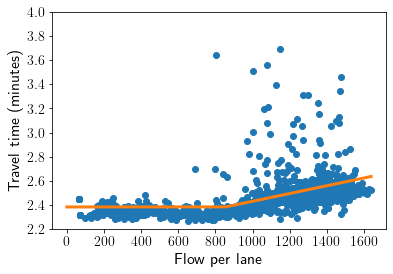

In [75]:
# flows_temp = [flow_time_tuple[0] for flow_time_tuple in flow_time_dict["Palo Alto"]]
# times_temp = [flow_time_tuple[1] for flow_time_tuple in flow_time_dict["Palo Alto"]]

# flows_temp = [flow_time_tuple[0] for flow_time_tuple in flow_time_dict["San Mateo"]]
# times_temp = [flow_time_tuple[1] for flow_time_tuple in flow_time_dict["San Mateo"]]

city_to_plot = city_list[-1]
# city_to_plot = "Palo Alto"

flows_to_plot = [flow_time_tuple[0] for flow_time_tuple in flow_time_dict[city_to_plot]]
times_to_plot = [flow_time_tuple[1]*60 for flow_time_tuple in flow_time_dict[city_to_plot]]

plt.plot(flows_to_plot, times_to_plot, "o")

flows_line_to_plot = np.arange(1, max(flows_to_plot))
times_line_to_plot = [latency_params[city_to_plot][0] \
                          + latency_params[city_to_plot][1] * max(flow - latency_params[city_to_plot][2], 0.0) \
                      for flow in flows_line_to_plot]

plt.plot(flows_line_to_plot, times_line_to_plot, linewidth=3)


# plt.xlim([0, 1600])
plt.ylim([2.2, 4.0])

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel(r'Flow per lane', fontsize=16)
# plt.ylabel('(Z, K) error gap \% (red, blue)', fontsize=16)
plt.ylabel(r'Travel time (minutes)', fontsize=16)

In [54]:
city_list

['Palo Alto',
 'East Palo Alto',
 'Redwood City',
 'Belmont',
 'San Mateo',
 'Burlingame',
 'Millbrae']

In [89]:
df_latency_params = pd.DataFrame.from_dict(latency_params)
# df_latency_params.rename(index={'0': 'new_row1', '2': 'new_row3'})
df_latency_params.index = ['Latency (at bend)', 'Slope (after bend)', 'Flow (at bend)']
df_latency_params = df_latency_params.reindex(index = ['Flow (at bend)', 'Latency (at bend)', 'Slope (after bend)'])
df_latency_params



,Palo Alto,East Palo Alto,Redwood City,Belmont,San Mateo,Burlingame,Millbrae
Flow (at bend),861.988500,1001.517857,881.184667,1278.948125,1034.092826,845.150000,853.181818
Time (at bend),1.326448,2.213127,4.892192,1.199911,5.541006,1.503111,2.384328
Slope (after bend),0.000783,0.000584,0.001564,0.001994,0.002147,0.000307,0.000322


In [90]:
directory_to_save = '../data/pems_latency_inference___101_N_Sep_to_Nov_2024/'
df_latency_params.to_csv(directory_to_save + 'latency_params.csv')



In [ ]:
np.arange(1, max(flows_to_plot))

In [ ]:
# TODO: 

# Create an dict of average speeds.
# Create a dict, from distances_between_sensors.xlsx, of distances betwen sub-edges in that city.

# For each city:
# For each date / hour timestap:
# Find flow vector along various sub-edges of that city at that timestamp. If each flow vector < 100, \
# ignore that timestamp. Otherwise, compute average flow for that city at that timestamp, and divide by num_gp_lanes.
# Compute the time necessary to travel through that city at that timestamp, \
# and add it to the (flow, time) tuple / array list for that city.


In [ ]:
# flow_thresh_low = 100


In [ ]:
directory_path = '../data/data_income_percentage_VoT/'
df_data = pd.read_excel(directory_path + 'data_cities_od_VoTs_demands_1.csv')

dict_data = {}

for column_name_full in list(df_data.columns):
    if column_name_full == "Data Category":
        categories_list = df_data[column_name_full].tolist()
    else:
        dict_data[int(column_name_full)] = {}
        for category_index, category in enumerate(categories_list):
            if category == "Start City Index" or category == "End City Index":
                dict_data[int(column_name_full)][category] \
                    = int(df_data[column_name_full].tolist()[category_index])
            elif category == "Start City" or category == "End City":
                dict_data[int(column_name_full)][category] \
                    = df_data[column_name_full].tolist()[category_index]
            else:
#                 print("category:", category)
                dict_data[int(column_name_full)][category] \
                    = float(df_data[column_name_full].tolist()[category_index])


# Scratch Work - Piecewise Linear Function

In [ ]:
# Link:
# https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

In [ ]:
p_list = list(p)
# p
# e

In [ ]:
p_list

# Scratch Work